In [1]:
import json
import numpy as np
import dicom
import os
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import random
from volume import *

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
v_dir = '/masvol/output/dsb/volume/'

In [3]:
method1_dirs = []
method2_dirs = []
for root, dirs, files in os.walk(v_dir+'1/'):
    for i in dirs:
        if os.path.isdir(root+i):
            method1_dirs.append(i)
for root, dirs, files in os.walk(v_dir+'2/'):
    for i in dirs:
        if os.path.isdir(root+i):
            method2_dirs.append(i)

In [4]:
dirs_176 = []
dirs_256 = []
methods = [method1_dirs,method2_dirs]
for i in range(len(methods)):
    for j in range(len(methods[i])):
        if ('_176_') in methods[i][j]:
            dirs_176.append(methods[i][j])
        elif ('_256_') in methods[i][j]:
            dirs_256.append(methods[i][j])

In [5]:
dirs_176.remove('3combined_1_3_0_176_aug_drop_dice_cr')
# dirs_256.remove('3combined_1_3_0_256_roi_aug_drop_dice')
# dirs_256.remove('3combined_1_3_0_256_roi_aug_dice')
# dirs_256.remove('3combined_1_3_0_256_roi_not_norm_dice')
# dirs_256.remove('3combined_1_3_0_256_roi_not_norm_drop_dice')
# dirs_256.remove('1combined_1_2_256_dice_aug_32B')

In [6]:
# v1_dict_256 = {}
# for i in range(len(dirs_176)):
#     print (dirs_176[i])
#     d = dirs_176[i]
#     splits = d.split('_')
#     if ('176') in d:
#         imgsize = 176
#     elif ('256') in d:
#         imgsize = 256
#     v=computeVolume(v_dir+splits[1]+'/'+dirs_176[i]+'/',imgsize, vtype='orig',STway='sub', ty=None)
    
#     train_df, validate_df, all_df = create_df(v)
#     all_no_outliers = removeOutliers(all_df,v, data=None)
# #     compute_rmse(all_no_outliers,'Tr + Val - Out')
#     all_no_out_noVol = removeNoVolume(all_no_outliers)
#     sys, dia, ef = compute_rmse(all_no_out_noVol,'Tr + Val - Out - Zero Vol')
#     v1_sys_low, v1_sys_high,sys_lows,sys_highs = estimateCheck(all_no_out_noVol, actual='Systole',predicted='Systole_P',dev=50)
#     v1_dia_low, v1_dia_high,dia_lows, dia_highs = estimateCheck(all_no_out_noVol, actual='Diastole',predicted='Diastole_P',dev=50)
    
#     if d in v1_dict:
#         v1_dict[d].update({'Systole RMSE': sys,
#                           'Diastole RMSE': dia,
#                           'EF RMSE': ef,
#                           '% Sys Low': v1_sys_low,
#                           '% Sys High': v1_sys_high,
#                           '% Dia Low': v1_dia_low, 
#                           '% Dia High': v1_dia_high, 
#                           'Sys Lows': sys_lows,
#                           'Sys Highs': sys_highs,
#                           'Dia Lows': dia_lows,
#                           'Dia Highs': dia_highs})
#     else:
#         v1_dict.update({d: {'Systole RMSE': sys,
#                           'Diastole RMSE': dia,
#                           'EF RMSE': ef,
#                           '% Sys Low': v1_sys_low,
#                           '% Sys High': v1_sys_high,
#                           '% Dia Low': v1_dia_low, 
#                           '% Dia High': v1_dia_high,
#                             'Sys Lows': sys_lows,
#                           'Sys Highs': sys_highs,
#                           'Dia Lows': dia_lows,
#                           'Dia Highs': dia_highs}})

In [7]:
def getbest(df, actual, predicted, dev):
    diff = df[actual]-df[predicted]
#     top_low = diff.index[diff < dev].tolist()
#     top_high = diff.index[diff > -dev].tolist()
    top = diff.index[(diff > -dev) & (diff < dev)].tolist()
#     print ('**********************')
#     print (diff)
    return (top)

In [10]:
def volDict(paths, diff, vtype='orig',STway='sub', ty=None):
    v_dict = {}
    no_data = []
    print (paths)
    for i in range(len(paths)):
        print (paths[i], i)
        d = paths[i]
        print (d[1:])
        splits = d.split('_')
        if ('176') in d:
            imgsize = 176
        elif ('256') in d:
            imgsize = 256
        v=computeVolume(v_dir+splits[1]+'/'+paths[i]+'/',imgsize, vtype='orig',STway='sub', ty=None)
        print (v_dir+splits[1]+'/'+paths[i]+'/')
#         print (v)
        if len(v.keys()) > 0:
            train_df, validate_df, all_df = create_df(v)
            all_no_outliers = removeOutliers(all_df,v, data=None)
            all_no_out_noVol = removeNoVolume(all_no_outliers)
            sys, dia, ef = compute_rmse(all_no_out_noVol,'Tr + Val - Out - Zero Vol')
            v1_sys_low, v1_sys_high,sys_lows,sys_highs = estimateCheck(all_no_out_noVol, actual='Systole',predicted='Systole_P',dev=diff)
            v1_dia_low, v1_dia_high,dia_lows, dia_highs = estimateCheck(all_no_out_noVol, actual='Diastole',predicted='Diastole_P',dev=diff)
            top_sys = getbest(all_no_out_noVol, actual='Systole',predicted='Systole_P',dev=1)
            top_dia = getbest(all_no_out_noVol, actual='Diastole',predicted='Diastole_P',dev=1)
#             print (v_dict)
            if d in v_dict:
#                 print ('****************'+d)
                v_dict[d[1:]].update({'Vol Method': vtype,
                                   'Systole RMSE': sys,
                                  'Diastole RMSE': dia,
                                  'EF RMSE': ef,
                                  '% Sys Low': v1_sys_low,
                                  '% Sys High': v1_sys_high,
                                  '% Dia Low': v1_dia_low, 
                                  '% Dia High': v1_dia_high, 
                                  'Sys Lows': sys_lows,
                                  'Sys Highs': sys_highs,
                                  'Dia Lows': dia_lows,
                                  'Dia Highs': dia_highs,
                                 'Top Sys': top_sys,
                                 'Top Dia': top_dia})
            else:
#                 print ('*************** ELSE')
                v_dict[d[1:]]=({'Vol Method': vtype,
                             'Systole RMSE': sys,
                                  'Diastole RMSE': dia,
                                  'EF RMSE': ef,
                                  '% Sys Low': v1_sys_low,
                                  '% Sys High': v1_sys_high,
                                  '% Dia Low': v1_dia_low, 
                                  '% Dia High': v1_dia_high,
                                    'Sys Lows': sys_lows,
                                  'Sys Highs': sys_highs,
                                  'Dia Lows': dia_lows,
                                  'Dia Highs': dia_highs,
                           'Top Sys': top_sys,
                           'Top Dia': top_dia})
        else:
            no_data.append(paths[i])
#     print (v_dict)
    return (v_dict, no_data)
        

In [11]:
v1_176, no_data_176 = volDict(dirs_176, 50)
v1_256, no_data_256 = volDict(dirs_256, 50)

['3combined_1_3_0_176_aug_dice', '3combined_1_3_176_aug_dice', '3combined_1_3_0_176_drop_dice', '3combined_1_3_0_176_aug_drop_dice', '3combined_1_3_176_aug_drop_dice', '2combined_1_2_176_dice_128b', '2combined_1_2_176_dice_aug_32B', '2combined_1_2_176_dice_aug_drop_32B', '2combined_1_2_176_dice_drop_32B', '1combined_1_1_176_dice_aug_32B', '1combined_1_1_176_dice_aug_drop_32B', '1combined_1_1_176_dice_drop_32B', '1combined_1_1_176_dice_reg_32B', '2combined_1_2_176_dice_32b', '2combined_1_2_176_dice_8b', '2combined_1_2_176_dice_64b', '2combined_1_2_176_dice_16b', '2combined_2_2_176_aug_dice', '2combined_2_2_176_aug_drop_dice', '1combined_2_1_176_aug_dice', '1combined_2_1_176_aug_drop_dice', '1combined_2_1_176_drop_dice', '1combined_2_1_176_dice', '2combined_2_2_176_drop_dice', '2combined_2_2_176_dice']
3combined_1_3_0_176_aug_dice 0
combined_1_3_0_176_aug_dice
/masvol/output/dsb/volume/1/3combined_1_3_0_176_aug_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.82 ml  Diastole RMSE: '19

/masvol/output/dsb/volume/1/2combined_1_2_176_dice_aug_32B/
Tr + Val - Out - Zero Vol :  Systole RMSE: 16.54 ml  Diastole RMSE: '21.64 ml  EF RMSE: 8.00 %
Systole : % Low Estimate: 0.0 % Correct Estimate:  32.0 % High Estimate:  1.0
Lows:  [269, 478, 676]
Highs:  [43, 298, 315, 352, 428, 429, 432, 534, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  24.0 % High Estimate:  3.0
Lows:  [269]
Highs:  [47, 135, 148, 237, 267, 298, 315, 339, 362, 428, 429, 432, 436, 465, 534, 561, 618, 643, 688, 692]
2combined_1_2_176_dice_aug_drop_32B 7
combined_1_2_176_dice_aug_drop_32B
/masvol/output/dsb/volume/1/2combined_1_2_176_dice_aug_drop_32B/
Tr + Val - Out - Zero Vol :  Systole RMSE: 18.46 ml  Diastole RMSE: '25.22 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 0.0 % Correct Estimate:  30.0 % High Estimate:  2.0
Lows:  [82, 478, 579]
Highs:  [43, 147, 261, 298, 315, 352, 428, 429, 467, 519, 534, 577, 630, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  22.0 % High Estimate:  5.0
L

/masvol/output/dsb/volume/2/2combined_2_2_176_aug_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.54 ml  Diastole RMSE: '22.25 ml  EF RMSE: 8.00 %
Systole : % Low Estimate: 1.0 % Correct Estimate:  33.0 % High Estimate:  1.0
Lows:  [269, 280, 478, 579]
Highs:  [298, 315, 341, 429, 432, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  26.0 % High Estimate:  3.0
Lows:  [269]
Highs:  [23, 47, 135, 148, 155, 173, 267, 287, 294, 298, 362, 371, 429, 432, 503, 534, 561, 618, 630, 643, 688, 692, 698]
2combined_2_2_176_aug_drop_dice 18
combined_2_2_176_aug_drop_dice
/masvol/output/dsb/volume/2/2combined_2_2_176_aug_drop_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 17.71 ml  Diastole RMSE: '23.08 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 1.0 % Correct Estimate:  31.0 % High Estimate:  1.0
Lows:  [8, 242, 269, 478]
Highs:  [248, 294, 298, 315, 341, 389, 429, 516, 685, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  23.0 % High Estimate:  4.0
Lows:  [269]
Highs:  [23, 

/masvol/output/dsb/volume/1/2combined_1_2_256_dice_drop_32B/
Tr + Val - Out - Zero Vol :  Systole RMSE: 22.58 ml  Diastole RMSE: '36.06 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 1.0 % Correct Estimate:  26.0 % High Estimate:  4.0
Lows:  [242, 274, 416, 676]
Highs:  [25, 120, 147, 197, 226, 229, 237, 248, 287, 315, 319, 352, 389, 417, 428, 429, 437, 444, 497, 518, 519, 533, 534, 577, 685, 687, 688, 698]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  17.0 % High Estimate:  12.0
Lows:  [274, 276, 416]
Highs:  [9, 20, 24, 25, 37, 40, 47, 51, 52, 60, 61, 64, 120, 126, 133, 144, 147, 148, 149, 152, 158, 168, 173, 197, 226, 229, 237, 241, 254, 258, 267, 271, 285, 287, 291, 298, 315, 319, 337, 343, 362, 371, 389, 396, 402, 408, 417, 428, 429, 436, 437, 444, 457, 467, 484, 497, 506, 518, 519, 523, 533, 534, 549, 561, 562, 569, 572, 577, 602, 615, 617, 618, 622, 643, 646, 650, 660, 666, 685, 687, 688, 692, 698]
2combined_1_2_256_dice_aug_drop_32B 7
combined_1_2_256_dice_aug_drop_32B
/ma

3combined_1_3_0_256_roi_not_norm_dice 15
combined_1_3_0_256_roi_not_norm_dice
/masvol/output/dsb/volume/1/3combined_1_3_0_256_roi_not_norm_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 77.10 ml  Diastole RMSE: '69.01 ml  EF RMSE: 40.00 %
Systole : % Low Estimate: 60.0 % Correct Estimate:  1.0 % High Estimate:  0.0
Lows:  [1, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 23, 27, 30, 33, 36, 42, 43, 44, 45, 46, 49, 50, 55, 58, 59, 63, 65, 67, 69, 71, 72, 73, 74, 75, 76, 78, 81, 82, 85, 86, 88, 91, 96, 97, 98, 99, 100, 103, 107, 109, 116, 117, 118, 119, 121, 124, 125, 126, 127, 130, 132, 134, 135, 136, 137, 140, 141, 142, 143, 145, 148, 150, 152, 155, 158, 160, 161, 165, 167, 170, 175, 178, 179, 180, 183, 184, 185, 186, 187, 189, 190, 195, 197, 198, 199, 203, 205, 207, 210, 211, 213, 214, 218, 220, 222, 226, 230, 231, 233, 235, 238, 239, 240, 241, 242, 244, 245, 246, 248, 249, 250, 253, 254, 256, 258, 259, 262, 265, 266, 268, 269, 270, 273, 274, 275, 276, 277, 280, 284, 290, 291, 292, 295, 2

/masvol/output/dsb/volume/2/2combined_2_2_256_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 24.92 ml  Diastole RMSE: '32.20 ml  EF RMSE: 10.00 %
Systole : % Low Estimate: 2.0 % Correct Estimate:  22.0 % High Estimate:  4.0
Lows:  [8, 78, 109, 127, 242, 262, 269, 274, 280, 416, 478, 579, 676]
Highs:  [24, 47, 120, 126, 147, 149, 182, 229, 236, 254, 267, 287, 315, 319, 352, 389, 417, 429, 432, 437, 497, 534, 536, 577, 583, 622, 665, 688, 698]
Diastole : % Low Estimate: 1.0 % Correct Estimate:  19.0 % High Estimate:  8.0
Lows:  [75, 262, 269, 274, 276, 280, 545, 620, 676]
Highs:  [9, 16, 23, 24, 37, 47, 60, 90, 96, 120, 126, 147, 148, 149, 181, 182, 195, 197, 228, 229, 241, 254, 267, 286, 287, 315, 319, 343, 352, 362, 366, 388, 389, 417, 428, 429, 432, 437, 481, 484, 486, 497, 503, 533, 534, 536, 561, 583, 611, 617, 618, 622, 643, 665, 684, 688, 692, 698]
2combined_2_2_256_aug_drop_dice 23
combined_2_2_256_aug_drop_dice
/masvol/output/dsb/volume/2/2combined_2_2_256_aug_drop_dice/
Tr + 

In [12]:
vz_176, no_data_176 = volDict(dirs_176, 50, vtype='zeros')
vz_256, no_data_256 = volDict(dirs_256, 50, vtype='zeros')

['3combined_1_3_0_176_aug_dice', '3combined_1_3_176_aug_dice', '3combined_1_3_0_176_drop_dice', '3combined_1_3_0_176_aug_drop_dice', '3combined_1_3_176_aug_drop_dice', '2combined_1_2_176_dice_128b', '2combined_1_2_176_dice_aug_32B', '2combined_1_2_176_dice_aug_drop_32B', '2combined_1_2_176_dice_drop_32B', '1combined_1_1_176_dice_aug_32B', '1combined_1_1_176_dice_aug_drop_32B', '1combined_1_1_176_dice_drop_32B', '1combined_1_1_176_dice_reg_32B', '2combined_1_2_176_dice_32b', '2combined_1_2_176_dice_8b', '2combined_1_2_176_dice_64b', '2combined_1_2_176_dice_16b', '2combined_2_2_176_aug_dice', '2combined_2_2_176_aug_drop_dice', '1combined_2_1_176_aug_dice', '1combined_2_1_176_aug_drop_dice', '1combined_2_1_176_drop_dice', '1combined_2_1_176_dice', '2combined_2_2_176_drop_dice', '2combined_2_2_176_dice']
3combined_1_3_0_176_aug_dice 0
combined_1_3_0_176_aug_dice
/masvol/output/dsb/volume/1/3combined_1_3_0_176_aug_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.82 ml  Diastole RMSE: '19

/masvol/output/dsb/volume/1/2combined_1_2_176_dice_aug_32B/
Tr + Val - Out - Zero Vol :  Systole RMSE: 16.54 ml  Diastole RMSE: '21.64 ml  EF RMSE: 8.00 %
Systole : % Low Estimate: 0.0 % Correct Estimate:  32.0 % High Estimate:  1.0
Lows:  [269, 478, 676]
Highs:  [43, 298, 315, 352, 428, 429, 432, 534, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  24.0 % High Estimate:  3.0
Lows:  [269]
Highs:  [47, 135, 148, 237, 267, 298, 315, 339, 362, 428, 429, 432, 436, 465, 534, 561, 618, 643, 688, 692]
2combined_1_2_176_dice_aug_drop_32B 7
combined_1_2_176_dice_aug_drop_32B
/masvol/output/dsb/volume/1/2combined_1_2_176_dice_aug_drop_32B/
Tr + Val - Out - Zero Vol :  Systole RMSE: 18.46 ml  Diastole RMSE: '25.22 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 0.0 % Correct Estimate:  30.0 % High Estimate:  2.0
Lows:  [82, 478, 579]
Highs:  [43, 147, 261, 298, 315, 352, 428, 429, 467, 519, 534, 577, 630, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  22.0 % High Estimate:  5.0
L

/masvol/output/dsb/volume/2/2combined_2_2_176_aug_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.54 ml  Diastole RMSE: '22.25 ml  EF RMSE: 8.00 %
Systole : % Low Estimate: 1.0 % Correct Estimate:  33.0 % High Estimate:  1.0
Lows:  [269, 280, 478, 579]
Highs:  [298, 315, 341, 429, 432, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  26.0 % High Estimate:  3.0
Lows:  [269]
Highs:  [23, 47, 135, 148, 155, 173, 267, 287, 294, 298, 362, 371, 429, 432, 503, 534, 561, 618, 630, 643, 688, 692, 698]
2combined_2_2_176_aug_drop_dice 18
combined_2_2_176_aug_drop_dice
/masvol/output/dsb/volume/2/2combined_2_2_176_aug_drop_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 17.71 ml  Diastole RMSE: '23.08 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 1.0 % Correct Estimate:  31.0 % High Estimate:  1.0
Lows:  [8, 242, 269, 478]
Highs:  [248, 294, 298, 315, 341, 389, 429, 516, 685, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  23.0 % High Estimate:  4.0
Lows:  [269]
Highs:  [23, 

/masvol/output/dsb/volume/1/2combined_1_2_256_dice_drop_32B/
Tr + Val - Out - Zero Vol :  Systole RMSE: 22.58 ml  Diastole RMSE: '36.06 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 1.0 % Correct Estimate:  26.0 % High Estimate:  4.0
Lows:  [242, 274, 416, 676]
Highs:  [25, 120, 147, 197, 226, 229, 237, 248, 287, 315, 319, 352, 389, 417, 428, 429, 437, 444, 497, 518, 519, 533, 534, 577, 685, 687, 688, 698]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  17.0 % High Estimate:  12.0
Lows:  [274, 276, 416]
Highs:  [9, 20, 24, 25, 37, 40, 47, 51, 52, 60, 61, 64, 120, 126, 133, 144, 147, 148, 149, 152, 158, 168, 173, 197, 226, 229, 237, 241, 254, 258, 267, 271, 285, 287, 291, 298, 315, 319, 337, 343, 362, 371, 389, 396, 402, 408, 417, 428, 429, 436, 437, 444, 457, 467, 484, 497, 506, 518, 519, 523, 533, 534, 549, 561, 562, 569, 572, 577, 602, 615, 617, 618, 622, 643, 646, 650, 660, 666, 685, 687, 688, 692, 698]
2combined_1_2_256_dice_aug_drop_32B 7
combined_1_2_256_dice_aug_drop_32B
/ma

/masvol/output/dsb/volume/1/3combined_1_3_0_256_roi_not_norm_drop_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 67.23 ml  Diastole RMSE: '85.65 ml  EF RMSE: 39.00 %
Systole : % Low Estimate: 55.00000000000001 % Correct Estimate:  3.0 % High Estimate:  0.0
Lows:  [501, 502, 505, 506, 507, 508, 512, 514, 515, 518, 519, 522, 524, 526, 527, 528, 529, 532, 536, 539, 540, 543, 544, 547, 549, 551, 554, 555, 557, 558, 562, 566, 567, 569, 570, 573, 576, 577, 578, 584, 585, 587, 592, 594, 596, 600, 601, 602, 605, 607, 609, 610, 613, 619, 620, 621, 625, 627, 628, 629, 630, 633, 637, 638, 641, 643, 647, 653, 654, 660, 661, 663, 664, 665, 666, 667, 669, 671, 672, 674, 682, 683, 685, 686, 694, 695, 696, 700]
Highs:  []
Diastole : % Low Estimate: 0.0 % Correct Estimate:  1.0 % High Estimate:  68.0
Lows:  []
Highs:  [501, 504, 505, 506, 507, 512, 514, 515, 519, 522, 523, 524, 527, 529, 530, 532, 533, 534, 536, 538, 540, 543, 544, 546, 547, 549, 551, 552, 554, 555, 559, 561, 562, 565, 566, 567, 569,

In [13]:
vst_176, no_data_176 = volDict(dirs_176, 50, vtype='ST')
vst_256, no_data_256 = volDict(dirs_256, 50, vtype='ST')

['3combined_1_3_0_176_aug_dice', '3combined_1_3_176_aug_dice', '3combined_1_3_0_176_drop_dice', '3combined_1_3_0_176_aug_drop_dice', '3combined_1_3_176_aug_drop_dice', '2combined_1_2_176_dice_128b', '2combined_1_2_176_dice_aug_32B', '2combined_1_2_176_dice_aug_drop_32B', '2combined_1_2_176_dice_drop_32B', '1combined_1_1_176_dice_aug_32B', '1combined_1_1_176_dice_aug_drop_32B', '1combined_1_1_176_dice_drop_32B', '1combined_1_1_176_dice_reg_32B', '2combined_1_2_176_dice_32b', '2combined_1_2_176_dice_8b', '2combined_1_2_176_dice_64b', '2combined_1_2_176_dice_16b', '2combined_2_2_176_aug_dice', '2combined_2_2_176_aug_drop_dice', '1combined_2_1_176_aug_dice', '1combined_2_1_176_aug_drop_dice', '1combined_2_1_176_drop_dice', '1combined_2_1_176_dice', '2combined_2_2_176_drop_dice', '2combined_2_2_176_dice']
3combined_1_3_0_176_aug_dice 0
combined_1_3_0_176_aug_dice
/masvol/output/dsb/volume/1/3combined_1_3_0_176_aug_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.82 ml  Diastole RMSE: '19

/masvol/output/dsb/volume/1/2combined_1_2_176_dice_aug_32B/
Tr + Val - Out - Zero Vol :  Systole RMSE: 16.54 ml  Diastole RMSE: '21.64 ml  EF RMSE: 8.00 %
Systole : % Low Estimate: 0.0 % Correct Estimate:  32.0 % High Estimate:  1.0
Lows:  [269, 478, 676]
Highs:  [43, 298, 315, 352, 428, 429, 432, 534, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  24.0 % High Estimate:  3.0
Lows:  [269]
Highs:  [47, 135, 148, 237, 267, 298, 315, 339, 362, 428, 429, 432, 436, 465, 534, 561, 618, 643, 688, 692]
2combined_1_2_176_dice_aug_drop_32B 7
combined_1_2_176_dice_aug_drop_32B
/masvol/output/dsb/volume/1/2combined_1_2_176_dice_aug_drop_32B/
Tr + Val - Out - Zero Vol :  Systole RMSE: 18.46 ml  Diastole RMSE: '25.22 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 0.0 % Correct Estimate:  30.0 % High Estimate:  2.0
Lows:  [82, 478, 579]
Highs:  [43, 147, 261, 298, 315, 352, 428, 429, 467, 519, 534, 577, 630, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  22.0 % High Estimate:  5.0
L

/masvol/output/dsb/volume/2/2combined_2_2_176_aug_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 15.54 ml  Diastole RMSE: '22.25 ml  EF RMSE: 8.00 %
Systole : % Low Estimate: 1.0 % Correct Estimate:  33.0 % High Estimate:  1.0
Lows:  [269, 280, 478, 579]
Highs:  [298, 315, 341, 429, 432, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  26.0 % High Estimate:  3.0
Lows:  [269]
Highs:  [23, 47, 135, 148, 155, 173, 267, 287, 294, 298, 362, 371, 429, 432, 503, 534, 561, 618, 630, 643, 688, 692, 698]
2combined_2_2_176_aug_drop_dice 18
combined_2_2_176_aug_drop_dice
/masvol/output/dsb/volume/2/2combined_2_2_176_aug_drop_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 17.71 ml  Diastole RMSE: '23.08 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 1.0 % Correct Estimate:  31.0 % High Estimate:  1.0
Lows:  [8, 242, 269, 478]
Highs:  [248, 294, 298, 315, 341, 389, 429, 516, 685, 688]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  23.0 % High Estimate:  4.0
Lows:  [269]
Highs:  [23, 

/masvol/output/dsb/volume/1/2combined_1_2_256_dice_drop_32B/
Tr + Val - Out - Zero Vol :  Systole RMSE: 22.58 ml  Diastole RMSE: '36.06 ml  EF RMSE: 9.00 %
Systole : % Low Estimate: 1.0 % Correct Estimate:  26.0 % High Estimate:  4.0
Lows:  [242, 274, 416, 676]
Highs:  [25, 120, 147, 197, 226, 229, 237, 248, 287, 315, 319, 352, 389, 417, 428, 429, 437, 444, 497, 518, 519, 533, 534, 577, 685, 687, 688, 698]
Diastole : % Low Estimate: 0.0 % Correct Estimate:  17.0 % High Estimate:  12.0
Lows:  [274, 276, 416]
Highs:  [9, 20, 24, 25, 37, 40, 47, 51, 52, 60, 61, 64, 120, 126, 133, 144, 147, 148, 149, 152, 158, 168, 173, 197, 226, 229, 237, 241, 254, 258, 267, 271, 285, 287, 291, 298, 315, 319, 337, 343, 362, 371, 389, 396, 402, 408, 417, 428, 429, 436, 437, 444, 457, 467, 484, 497, 506, 518, 519, 523, 533, 534, 549, 561, 562, 569, 572, 577, 602, 615, 617, 618, 622, 643, 646, 650, 660, 666, 685, 687, 688, 692, 698]
2combined_1_2_256_dice_aug_drop_32B 7
combined_1_2_256_dice_aug_drop_32B
/ma

/masvol/output/dsb/volume/1/3combined_1_3_0_256_roi_not_norm_drop_dice/
Tr + Val - Out - Zero Vol :  Systole RMSE: 67.23 ml  Diastole RMSE: '85.65 ml  EF RMSE: 39.00 %
Systole : % Low Estimate: 55.00000000000001 % Correct Estimate:  3.0 % High Estimate:  0.0
Lows:  [501, 502, 505, 506, 507, 508, 512, 514, 515, 518, 519, 522, 524, 526, 527, 528, 529, 532, 536, 539, 540, 543, 544, 547, 549, 551, 554, 555, 557, 558, 562, 566, 567, 569, 570, 573, 576, 577, 578, 584, 585, 587, 592, 594, 596, 600, 601, 602, 605, 607, 609, 610, 613, 619, 620, 621, 625, 627, 628, 629, 630, 633, 637, 638, 641, 643, 647, 653, 654, 660, 661, 663, 664, 665, 666, 667, 669, 671, 672, 674, 682, 683, 685, 686, 694, 695, 696, 700]
Highs:  []
Diastole : % Low Estimate: 0.0 % Correct Estimate:  1.0 % High Estimate:  68.0
Lows:  []
Highs:  [501, 504, 505, 506, 507, 512, 514, 515, 519, 522, 523, 524, 527, 529, 530, 532, 533, 534, 536, 538, 540, 543, 544, 546, 547, 549, 551, 552, 554, 555, 559, 561, 562, 565, 566, 567, 569,

In [14]:
v1_176_df=pd.DataFrame.from_dict(v1_176, orient='index')
v1_256_df=pd.DataFrame.from_dict(v1_256, orient='index')
v_orig = pd.concat([v1_176_df, v1_256_df], axis=0)
vz_176_df=pd.DataFrame.from_dict(vz_176, orient='index')
vz_256_df=pd.DataFrame.from_dict(vz_256, orient='index')
v_zeros = pd.concat([vz_176_df, vz_256_df], axis=0)
vst_176_df=pd.DataFrame.from_dict(vst_176, orient='index')
vst_256_df=pd.DataFrame.from_dict(vst_256, orient='index')
v_st = pd.concat([vst_176_df, vst_256_df], axis=0)

In [15]:
v_orig

,% Dia Low,Top Dia,Diastole RMSE,% Dia High,% Sys High,Vol Method,Dia Highs,EF RMSE,Top Sys,Systole RMSE,% Sys Low,Dia Lows,Sys Highs,Sys Lows
combined_1_1_176_dice_aug_32B,0.0,"[28, 33, 63, 76, 79, 87, 95, 114, 115, 119, 14...",19.60,2.0,0.0,orig,"[126, 148, 149, 173, 267, 298, 362, 429, 432, ...",8.0,"[1, 31, 54, 59, 67, 79, 81, 85, 92, 100, 126, ...",15.49,1.0,"[269, 545, 600]","[315, 429]","[269, 280, 478, 676]"
combined_1_1_176_dice_aug_drop_32B,0.0,"[4, 13, 28, 34, 41, 72, 87, 104, 159, 171, 176...",20.11,2.0,1.0,orig,"[126, 149, 173, 229, 298, 315, 362, 371, 429, ...",8.0,"[15, 33, 45, 50, 63, 76, 81, 98, 101, 128, 129...",15.23,1.0,[545],"[298, 315, 429, 685]","[8, 82, 242, 269, 437, 676]"
combined_1_1_176_dice_drop_32B,1.0,"[67, 157, 178, 239, 323, 332, 335, 354, 374, 3...",38.89,15.0,8.0,orig,"[9, 16, 23, 31, 36, 37, 38, 46, 47, 56, 60, 64...",10.0,"[42, 53, 70, 138, 169, 193, 231, 275, 306, 334...",31.52,1.0,"[262, 269, 276, 280, 545, 600]","[36, 47, 56, 71, 120, 126, 135, 147, 149, 179,...","[242, 269, 274, 276, 280, 349, 416, 478, 600, ..."
combined_1_1_176_dice_reg_32B,1.0,"[2, 171, 175, 190, 204, 283, 313, 356, 376, 43...",33.85,9.0,7.0,orig,"[9, 23, 31, 56, 71, 96, 97, 120, 126, 147, 149...",10.0,"[1, 4, 6, 16, 17, 21, 33, 53, 57, 65, 72, 100,...",27.71,1.0,"[75, 172, 262, 269, 276, 280, 600, 676]","[56, 71, 97, 120, 126, 147, 149, 164, 166, 199...","[242, 269, 274, 276, 280, 349, 416, 478, 600, ..."
combined_1_2_176_dice_128b,0.0,[],2202.22,100.0,100.0,orig,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",54.0,[],2161.04,0.0,[],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",[]
combined_1_2_176_dice_16b,97.0,[212],158.64,0.0,0.0,orig,[],59.0,[],68.50,45.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",[],"[1, 5, 6, 8, 10, 15, 16, 17, 18, 19, 20, 21, 2..."
combined_1_2_176_dice_32b,1.0,"[18, 20, 41, 66, 82, 151, 157, 162, 164, 171, ...",27.03,6.0,2.0,orig,"[9, 47, 120, 126, 140, 147, 148, 149, 173, 229...",9.0,"[14, 45, 48, 54, 77, 101, 150, 173, 187, 190, ...",20.12,1.0,"[172, 269, 276, 279, 280, 412, 416, 478, 545]","[9, 147, 229, 236, 352, 410, 428, 429, 516, 53...","[82, 269, 274, 276, 280, 349, 416, 478, 579, 676]"
combined_1_2_176_dice_64b,2.0,"[28, 48, 57, 102, 115, 151, 199, 235, 247, 256...",26.18,3.0,1.0,orig,"[9, 47, 120, 126, 147, 148, 149, 197, 229, 267...",9.0,"[38, 45, 54, 112, 122, 133, 151, 163, 170, 232...",19.65,2.0,"[75, 172, 269, 274, 276, 279, 280, 416, 478, 5...","[147, 229, 352, 429, 536, 583, 688, 698]","[8, 82, 127, 269, 274, 276, 280, 349, 416, 452..."
combined_1_2_176_dice_8b,2.0,"[26, 28, 30, 67, 82, 112, 117, 150, 166, 175, ...",26.10,4.0,1.0,orig,"[23, 47, 147, 149, 173, 229, 267, 287, 294, 29...",9.0,"[6, 17, 33, 54, 57, 84, 98, 101, 108, 115, 116...",20.63,2.0,"[75, 172, 262, 269, 274, 276, 279, 280, 416, 4...","[147, 229, 352, 410, 429, 516, 536, 583, 630, ...","[8, 242, 262, 269, 274, 276, 280, 349, 478, 49..."
combined_1_2_176_dice_aug_32B,0.0,"[19, 67, 69, 82, 109, 112, 117, 174, 176, 235,...",21.64,3.0,1.0,orig,"[47, 135, 148, 237, 267, 298, 315, 339, 362, 4...",8.0,"[31, 54, 81, 101, 121, 126, 137, 149, 150, 170...",16.54,0.0,[269],"[43, 298, 315, 352, 428, 429, 432, 534, 688]","[269, 478, 676]"


In [14]:
# v_orig[[v_orig['Systole RMSE'] < 16]]
best_sys = v_orig.loc[v_orig['Systole RMSE'] < 16].sort_values(by='Systole RMSE')
best_dia = v_orig.loc[v_orig['Diastole RMSE'] < 21].sort_values(by='Diastole RMSE')

In [15]:
a=best_sys['Top Dia'].values
tmp = []
for i in range(len(a)):
    for j in range(len(a[i])):
        tmp.append(a[i][j])
[[x,tmp.count(x)] for x in set(tmp)]

[[4, 1],
 [7, 1],
 [520, 1],
 [519, 1],
 [8, 1],
 [11, 3],
 [10, 1],
 [13, 1],
 [526, 2],
 [525, 1],
 [530, 1],
 [535, 1],
 [24, 1],
 [539, 2],
 [28, 2],
 [540, 2],
 [542, 1],
 [27, 1],
 [33, 1],
 [34, 1],
 [550, 1],
 [41, 1],
 [554, 1],
 [555, 1],
 [44, 1],
 [559, 1],
 [563, 1],
 [565, 1],
 [567, 1],
 [568, 2],
 [569, 1],
 [570, 1],
 [572, 1],
 [63, 1],
 [575, 1],
 [576, 1],
 [580, 1],
 [72, 1],
 [587, 2],
 [76, 1],
 [79, 1],
 [80, 1],
 [596, 2],
 [87, 2],
 [606, 1],
 [95, 1],
 [608, 1],
 [99, 1],
 [613, 1],
 [102, 1],
 [104, 1],
 [623, 1],
 [113, 1],
 [626, 1],
 [114, 3],
 [115, 1],
 [628, 1],
 [625, 1],
 [119, 1],
 [631, 1],
 [133, 2],
 [647, 1],
 [651, 4],
 [652, 2],
 [653, 1],
 [142, 1],
 [143, 1],
 [144, 1],
 [656, 1],
 [659, 2],
 [661, 1],
 [150, 3],
 [151, 3],
 [664, 1],
 [667, 1],
 [669, 2],
 [157, 1],
 [159, 2],
 [677, 1],
 [680, 1],
 [171, 1],
 [685, 2],
 [687, 1],
 [176, 2],
 [689, 1],
 [690, 1],
 [180, 1],
 [182, 1],
 [694, 2],
 [696, 3],
 [184, 1],
 [186, 1],
 [187, 4],
 

In [16]:
base_path = "/masvol/output/dsb/norm/"
method = '1'
Type = '1'
source = 'validate'
model = 'combined_1_1_176_dice_aug_drop_32B'
img = '685'
frames = 'maxframes'

/masvol/output/dsb/norm/1/1/unet_model_validate/data/dsb_685_176_train.npy
/masvol/output/dsb/norm/1/1/unet_model_validate/combined_1_1_176_dice_aug_drop_32B_predict/dsb_685_176_pred_round.npy
/masvol/output/dsb/norm/1/1/unet_model_validate/data/dsb_685_image_path.txt
samples, max, min  420 1.0 0.0
/masvol/output/dsb/norm/1/1/validate/685/sax_15_IM-4397-0002.dcm.npy


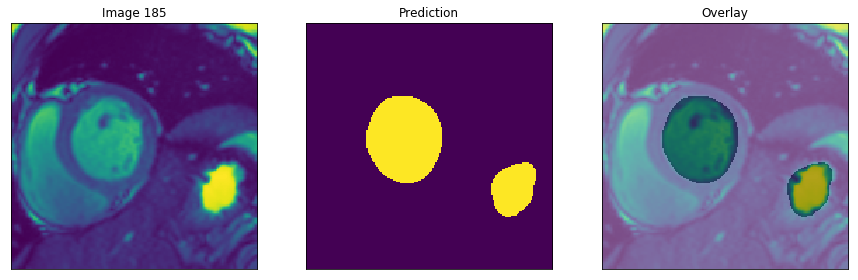

/masvol/output/dsb/norm/1/1/validate/685/sax_20_IM-4402-0002.dcm.npy


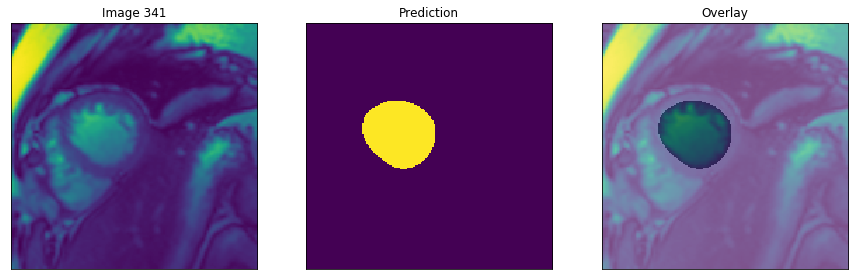

/masvol/output/dsb/norm/1/1/validate/685/sax_21_IM-4403-0029.dcm.npy


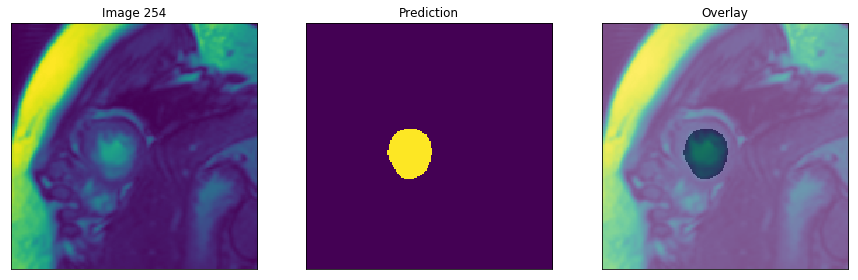

/masvol/output/dsb/norm/1/1/validate/685/sax_16_IM-4398-0030.dcm.npy


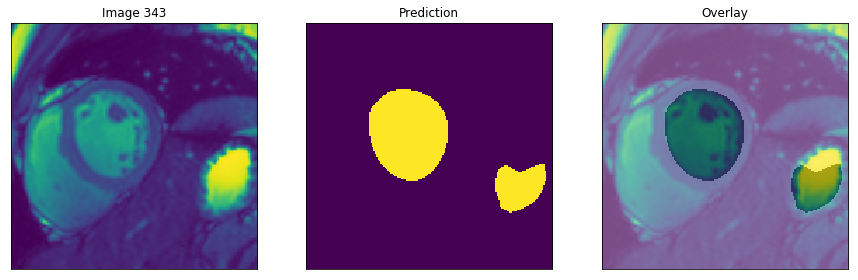

/masvol/output/dsb/norm/1/1/validate/685/sax_10_IM-4392-0029.dcm.npy


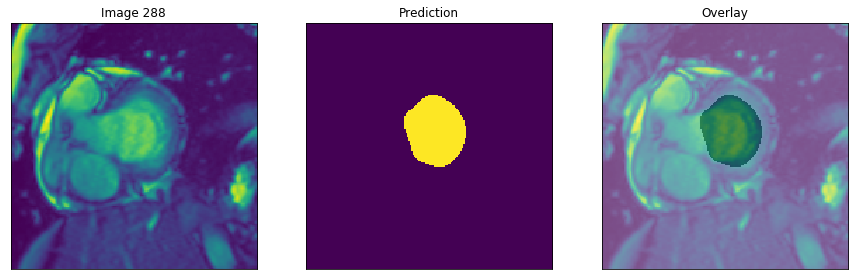

/masvol/output/dsb/norm/1/1/validate/685/sax_12_IM-4394-0029.dcm.npy


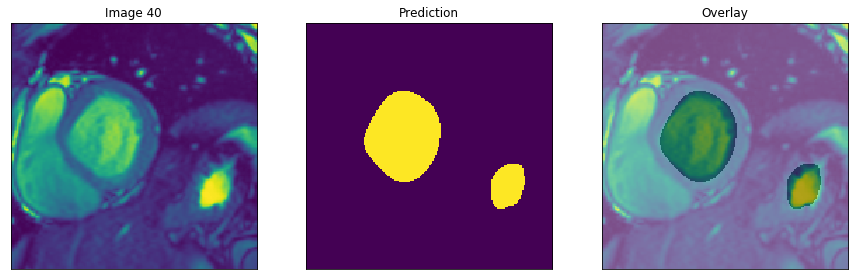

/masvol/output/dsb/norm/1/1/validate/685/sax_23_IM-4405-0015.dcm.npy


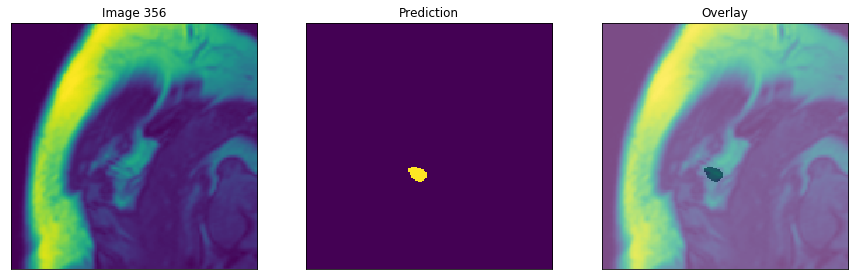

/masvol/output/dsb/norm/1/1/validate/685/sax_22_IM-4404-0029.dcm.npy


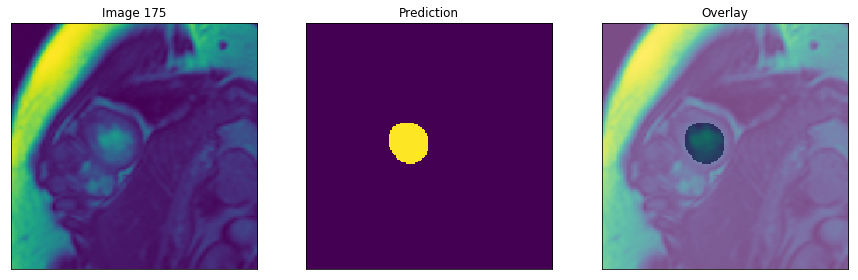

/masvol/output/dsb/norm/1/1/validate/685/sax_14_IM-4396-0030.dcm.npy


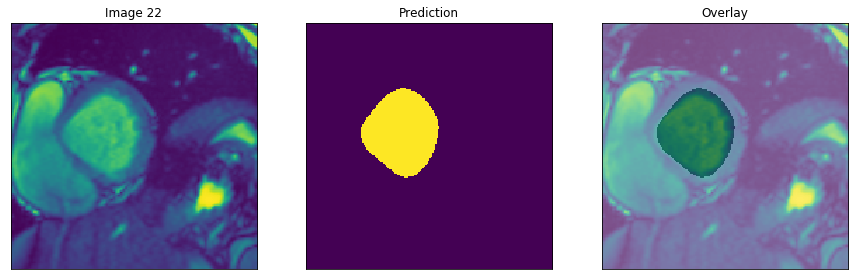

/masvol/output/dsb/norm/1/1/validate/685/sax_17_IM-4399-0030.dcm.npy


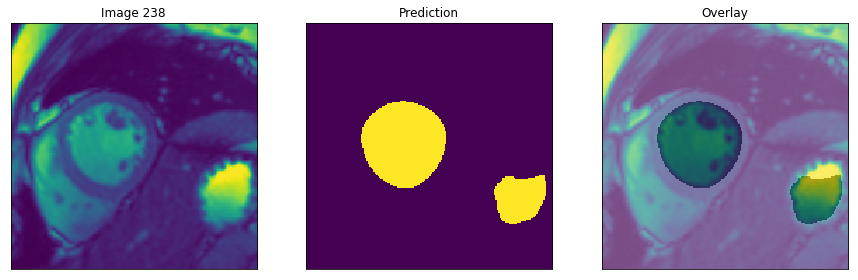

/masvol/output/dsb/norm/1/1/validate/685/sax_19_IM-4401-0030.dcm.npy


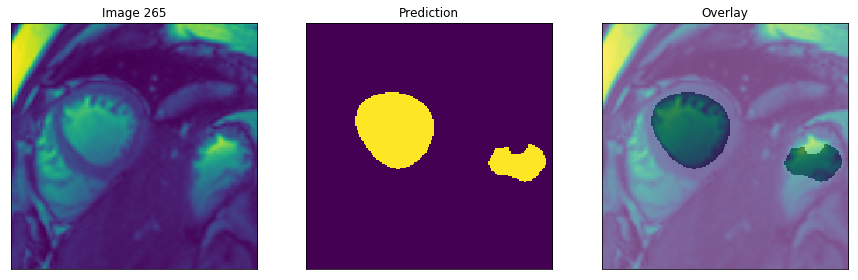

/masvol/output/dsb/norm/1/1/validate/685/sax_11_IM-4393-0001.dcm.npy


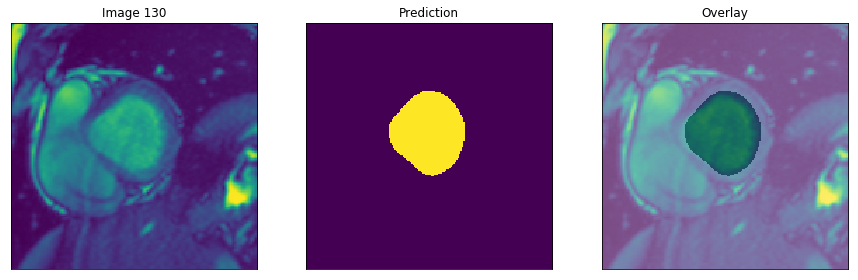

/masvol/output/dsb/norm/1/1/validate/685/sax_18_IM-4400-0002.dcm.npy


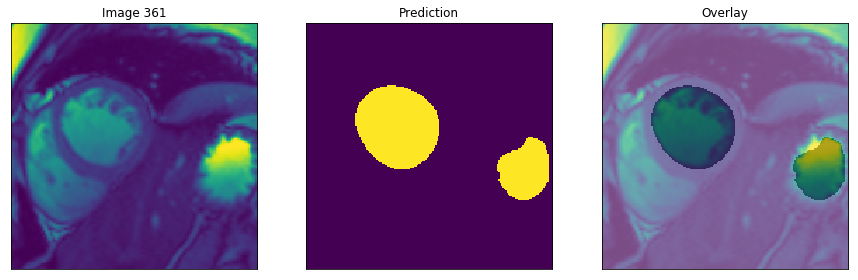

/masvol/output/dsb/norm/1/1/validate/685/sax_13_IM-4395-0030.dcm.npy


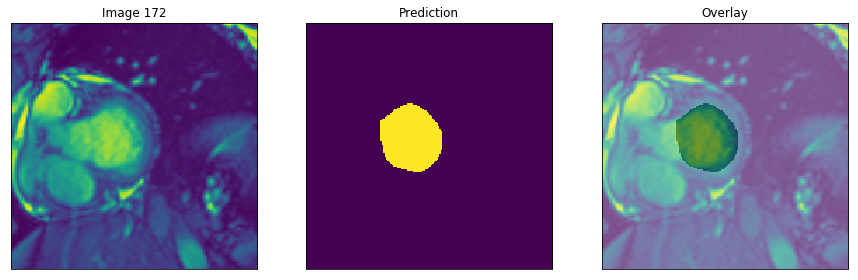

In [17]:
image_file = base_path+method+'/'+Type+'/unet_model_'+source+'/data/'+'dsb_'+img+'_176_train.npy'
pred_file = base_path+method+'/'+Type+'/unet_model_'+source+'/'+model+'_predict/'+'dsb_'+img+'_176_pred_round.npy'
img_txt = base_path+method+'/'+Type+'/unet_model_'+source+'/data/'+'dsb_'+img+'_image_path.txt'
print (image_file)
print (pred_file)
print (img_txt)
# vol_path = '/masvol/output/dsb/volume/1/1combined_1_1_176_dice_aug_drop_32B/'
vol_path = '/masvol/output/dsb/volume/'+method+'/'+Type+model+'/'
# print (vol_path,vol_path_t)
# v = computeVolume('/masvol/output/dsb/volume/1/1combined_1_1_176_dice_aug_drop_32B/',176, vtype='orig',STway='sub', ty=None)
v = computeVolume(vol_path,176, vtype='orig',STway='sub', ty=None)
plot_outlier_imgs(image_file, pred_file, method,Type,img_txt,v,image = img,frames = frames)

In [18]:
v_orig.loc['3combined_1_3_0_256_roi_aug_drop_dice']['Sys Lows']

[1,
 4,
 5,
 6,
 7,
 8,
 10,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 27,
 30,
 33,
 36,
 42,
 43,
 44,
 45,
 46,
 50,
 51,
 55,
 58,
 59,
 62,
 63,
 65,
 67,
 69,
 71,
 72,
 73,
 74,
 75,
 77,
 78,
 81,
 82,
 85,
 86,
 88,
 91,
 96,
 99,
 100,
 102,
 103,
 107,
 109,
 115,
 116,
 117,
 118,
 119,
 121,
 124,
 125,
 127,
 130,
 131,
 132,
 134,
 136,
 140,
 142,
 143,
 145,
 146,
 148,
 150,
 152,
 154,
 155,
 158,
 160,
 161,
 163,
 165,
 166,
 167,
 170,
 175,
 179,
 180,
 183,
 184,
 185,
 186,
 187,
 189,
 195,
 197,
 199,
 201,
 203,
 205,
 207,
 210,
 211,
 213,
 214,
 218,
 220,
 222,
 226,
 228,
 230,
 231,
 235,
 236,
 238,
 239,
 242,
 245,
 246,
 247,
 249,
 250,
 253,
 256,
 258,
 262,
 265,
 268,
 269,
 270,
 273,
 274,
 275,
 276,
 277,
 280,
 287,
 288,
 290,
 291,
 292,
 295,
 298,
 299,
 300,
 301,
 302,
 303,
 304,
 308,
 309,
 311,
 312,
 314,
 316,
 332,
 333,
 335,
 339,
 341,
 346,
 347,
 348,
 349,
 352,
 353,
 354,
 355,
 356,
 357,
 359,
 360,
 363,
 366,
 368,

In [73]:
num_zero_esv = 0
esv_zeros = []
esv_non_zeros = []
num_big_edv = 0
edv_big = []
for i in v:
    if v[i]['ESV'] == 0:
        num_zero_esv += 1
        esv_zeros.append(i)
    if (v[i]['ESV'] < 150) and (v[i]['ESV'] >5):
        esv_non_zeros.append(i)
    if v[i]['EDV'] > 150:
        num_big_edv += 1
        edv_big.append(i)
print(num_zero_esv, num_big_edv, len(esv_non_zeros))

142 615 329


In [105]:
base_path = "/masvol/output/dsb/norm/"
method = '1'
Type = '3'
source = 'train'
model = 'combined_1_3_0_256_roi_aug_dice' #or combined_1_3_0_256_roi_aug_drop_dice
img = '34'
frames = 'maxframes'

In [106]:
image_file = base_path+method+'/'+Type+'/unet_model_'+source+'_roi_norm/data/'+'dsb_'+img+'_256_'+source+'.npy'
pred_file = base_path+method+'/'+Type+'/unet_model_'+source+'_roi_norm/'+model+'_predict/'+'dsb_'+img+'_256_pred_round.npy'
img_txt = base_path+method+'/'+Type+'/unet_model_'+source+'/data/'+'dsb_'+img+'_image_path.txt'
vol_path = '/masvol/output/dsb/volume/'+method+'/'+Type+model+'/'
print (image_file, pred_file, img_txt, vol_path)
v = computeVolume(vol_path,256, vtype='orig',STway='sub', ty=None)

/masvol/output/dsb/norm/1/3/unet_model_train_roi_norm/data/dsb_34_256_train.npy /masvol/output/dsb/norm/1/3/unet_model_train_roi_norm/combined_1_3_0_256_roi_aug_dice_predict/dsb_34_256_pred_round.npy /masvol/output/dsb/norm/1/3/unet_model_train/data/dsb_34_image_path.txt /masvol/output/dsb/volume/1/3combined_1_3_0_256_roi_aug_dice/


In [112]:
pred_file

'/masvol/output/dsb/norm/1/3/unet_model_train_roi_norm/combined_1_3_0_256_roi_aug_dice_predict/dsb_34_256_pred_round.npy'

samples, max, min  300 1.0 0.0
/masvol/output/dsb/norm/1/3/train/34/sax_49_IM-13937-0019.dcm.npy


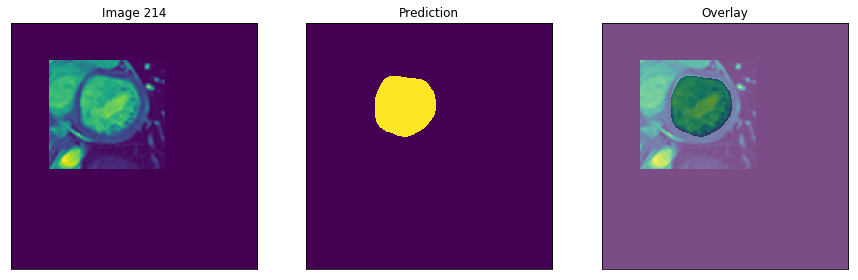

/masvol/output/dsb/norm/1/3/train/34/sax_52_IM-13940-0019.dcm.npy


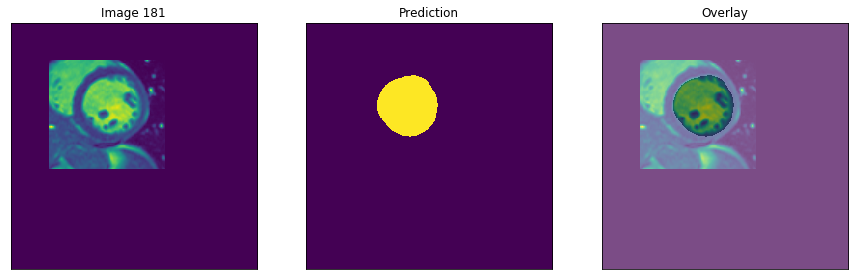

/masvol/output/dsb/norm/1/3/train/34/sax_50_IM-13938-0008.dcm.npy


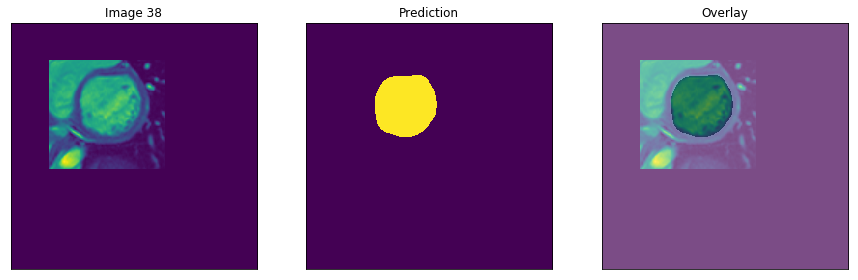

/masvol/output/dsb/norm/1/3/train/34/sax_51_IM-13939-0023.dcm.npy


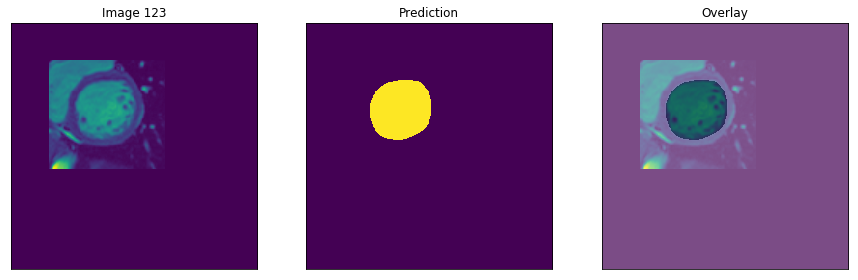

/masvol/output/dsb/norm/1/3/train/34/sax_46_IM-13934-0010.dcm.npy


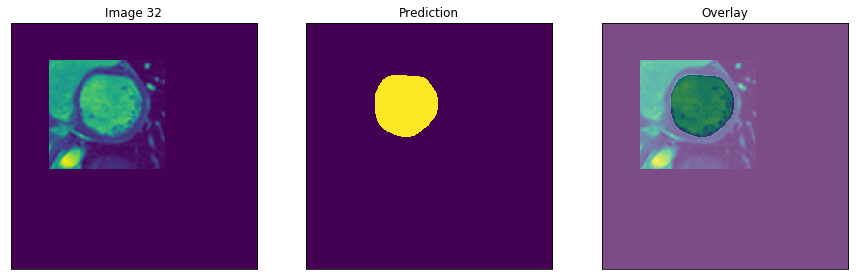

/masvol/output/dsb/norm/1/3/train/34/sax_54_IM-13942-0029.dcm.npy


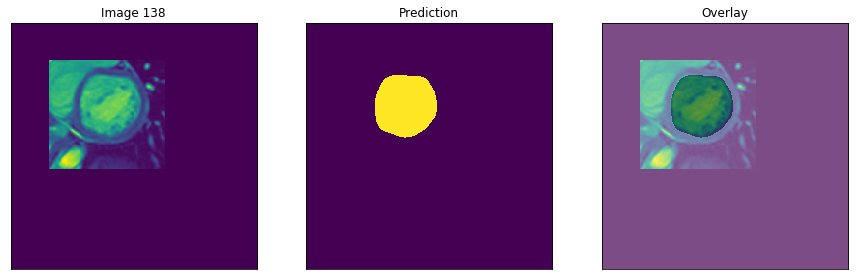

/masvol/output/dsb/norm/1/3/train/34/sax_55_IM-13943-0028.dcm.npy


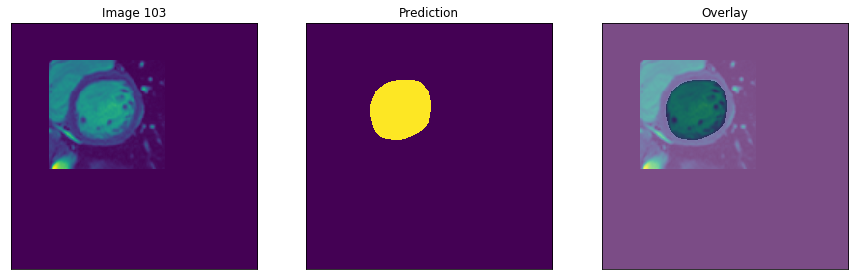

/masvol/output/dsb/norm/1/3/train/34/sax_47_IM-13935-0030.dcm.npy


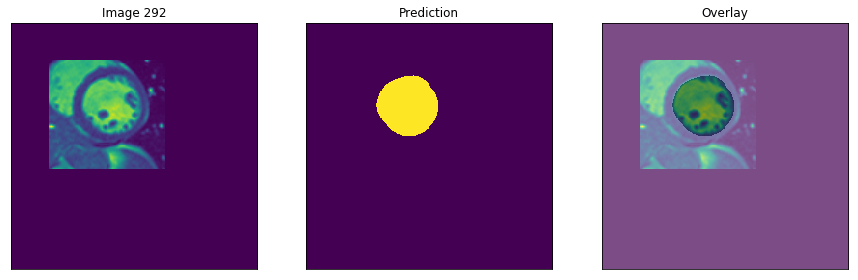

/masvol/output/dsb/norm/1/3/train/34/sax_53_IM-13941-0028.dcm.npy


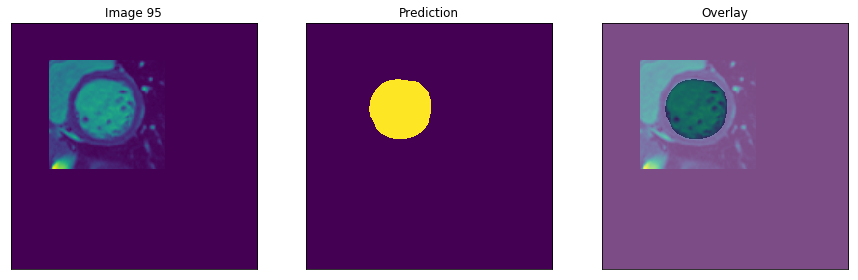

/masvol/output/dsb/norm/1/3/train/34/sax_48_IM-13936-0006.dcm.npy


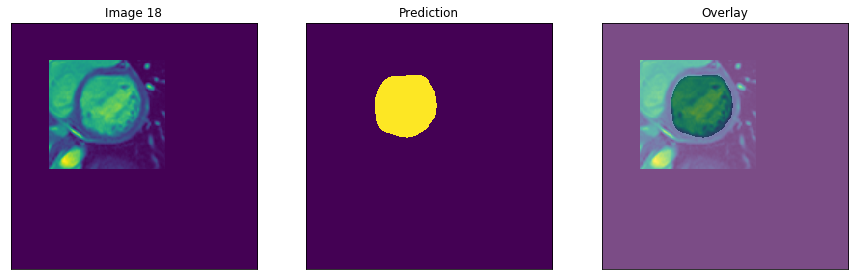

In [107]:
plot_outlier_imgs(image_file, pred_file, method,Type,img_txt,v,image = img,frames = frames)

In [108]:
train_df, validate_df, all_df = create_df(v)

In [109]:
all_df.loc[(all_df['Diastole_diff']<5) & (all_df['Diastole_diff']>-5)]

,Systole,Diastole,Systole_P,Diastole_P,Systole_diff,Diastole_diff,EF_P,EF
Id,,,,,,,,
5,83.3,235.5,9.655005,235.265111,73.644995,0.234889,0.958961,0.646285
73,82.8,190.1,4.909998,187.089923,77.890002,3.010077,0.973756,0.564440
123,24.4,88.3,0.640000,92.840001,23.760000,-4.540001,0.993106,0.723669
200,50.9,138.3,7.130002,136.585036,43.769998,1.714964,0.947798,0.631960
232,39.6,142.0,7.780000,141.580007,31.820000,0.419993,0.945049,0.721127
283,30.7,88.7,7.199820,91.563538,23.500180,-2.863538,0.921368,0.653890
604,39.2,119.6,5.225001,119.785024,33.974999,-0.185024,0.956380,0.672241


In [110]:
all_df.loc[(all_df['Diastole_diff']<-50)]

,Systole,Diastole,Systole_P,Diastole_P,Systole_diff,Diastole_diff,EF_P,EF
Id,,,,,,,,
4,57.7,154.5,1.085000,210.409986,56.615000,-55.909986,0.994843,0.626537
6,225.3,317.9,11.439998,467.774897,213.860002,-149.874897,0.975544,0.291287
7,64.9,138.0,5.449999,213.114926,59.450001,-75.114926,0.974427,0.529710
8,158.3,305.5,10.075001,423.780067,148.224999,-118.280067,0.976226,0.481833
9,61.4,152.2,13.554998,253.434935,47.845002,-101.234935,0.946515,0.596583
10,105.2,219.3,0.000000,416.274781,105.200000,-196.974781,1.000000,0.520292
14,50.1,175.2,1.330000,260.100023,48.770000,-84.900023,0.994887,0.714041
16,117.6,204.3,31.254986,281.629864,86.345014,-77.329864,0.889021,0.424376
18,107.9,174.3,9.055000,225.165009,98.845000,-50.865009,0.959785,0.380952


In [114]:
all_df.loc[(all_df['Systole_P']==0)]

,Systole,Diastole,Systole_P,Diastole_P,Systole_diff,Diastole_diff,EF_P,EF
Id,,,,,,,,
10,105.20,219.30,0.0,416.274781,105.20,-196.974781,1.0,0.520292
12,27.80,93.50,0.0,120.069993,27.80,-26.569993,1.0,0.702674
20,72.40,162.30,0.0,218.614993,72.40,-56.314993,1.0,0.553913
22,44.10,124.20,0.0,178.003854,44.10,-53.803854,1.0,0.644928
23,83.00,168.00,0.0,307.169995,83.00,-139.169995,1.0,0.505952
24,24.50,82.20,0.0,104.392029,24.50,-22.192029,1.0,0.701946
25,35.80,120.60,0.0,171.629988,35.80,-51.029988,1.0,0.703151
28,46.20,122.20,0.0,164.764963,46.20,-42.564963,1.0,0.621931
29,15.60,44.20,0.0,59.554743,15.60,-15.354743,1.0,0.647059


In [16]:
v_orig[['Systole RMSE','Diastole RMSE','EF RMSE']].to_csv('Volume_0520.csv')